# SETUP

## Check environment

In [1]:
USE_GPU = True

In [2]:
try:
    import google.colab
    COLAB = True
except:
    COLAB = False
print(f"Using Google Colab: {COLAB}")

Using Google Colab: False


## Libraries

In [33]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K

# Append the custom libraries to system path
if COLAB:
    sys.path.append("/content/air_quality_index_project")

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_prediction
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction
from src.loop_model import generate_loopresults, choose_the_best
from src.reduce_data_utils import prepareReducedData, augmentReducedData
from src.data_utils import mice
from src.time_series_utils import check_stationarity

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

Using GPU to train
2.20.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [34]:
if COLAB:
    confReader = ConfigurationReader("/content/air_quality_index_project/model_params_colab.json")
else:
    confReader = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json")
print(confReader)

conf = confReader.data

# Clear all temp folders
def cleanDir(input_dir):
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)
    os.makedirs(input_dir)

#cleanDir(conf["workspace"]["model_info_dir"])
#cleanDir(conf["workspace"]["model_checkpoints_dir"])
#cleanDir(conf["workspace"]["data_statistic_dir"])
#cleanDir(conf["workspace"]["data_by_station_dir"])
#cleanDir(conf["workspace"]["data_by_location_dir"])
cleanDir(conf["workspace"]["best_reduction_models_dir"])
cleanDir(conf["workspace"]["best_reduced_data"])

{
    "dataset": {
        "aod2022": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx",
            "target_start_date": "2022-01-01",
            "target_end_date": "2022-12-31"
        },
        "aod2021": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/aod_data_daily.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2021-12-31"
        },
        "mpair": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2022-12-31",
            "station_2022_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2022.csv",
            "station_2018_2021_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2018-2021.c

# AOD DATA

## Load 2022 dataset

In [35]:
df_aod_raw_2022 = pd.read_excel(conf["dataset"]["aod2022"]["file_dir"])

print(df_aod_raw_2022.columns)
df_aod_raw_2022

Index(['time', 'ID', 'pm25', 'lat', 'lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'PRES2M', 'AOD', 'OID', 'POP', 'ROAD_DEN_1km',
       'PRIM_ROAD_LEN_1km', 'NEAR_DIST', 'BARELAND', 'BUILTUP', 'CROPLAND',
       'GRASSLAND', 'TREECOVER', 'WATER', 'NDVI', 'Name'],
      dtype='object')


,time,ID,pm25,lat,lon,PM25_3km,TMP,RH,HPBL,WSPD,...,PRIM_ROAD_LEN_1km,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI,Name
0,2022-01-01,S4,23.768238,10.815839,106.717396,22.025597,28.261583,57.233841,721.996887,2.003031,...,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486,"Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn..."
1,2022-01-01,S5,14.221014,10.776415,106.687955,22.705284,27.787918,61.073841,659.863586,1.885687,...,7249.776367,21.703104,395.082094,877872.4121,0.00000,98.770523,121487.74380,0.00000,1721.431568,Tòa soạn Báo Thanh Niên - Nguyễn Đình Chiểu - Q3
2,2022-01-01,S6,21.405015,10.780482,106.659511,23.503082,27.787918,61.073841,659.863586,1.885687,...,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348,"MobiFone Thành Thái, Q10"
3,2022-01-01,S7,21.695652,10.783456,106.700622,22.705284,27.787918,61.073841,659.863586,1.885687,...,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924,ĐSQ Mỹ
4,2022-01-02,S4,22.154723,10.815839,106.717396,22.711113,25.827082,57.916595,619.779785,1.286289,...,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486,"Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,2022-12-30,S6,33.091428,10.780482,106.659511,19.854403,24.979719,64.868401,680.533081,3.893373,...,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348,"MobiFone Thành Thái, Q10"
994,2022-12-30,S7,40.166667,10.783456,106.700622,19.137615,24.979719,64.868401,680.533081,3.893373,...,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924,ĐSQ Mỹ
995,2022-12-31,S4,27.879261,10.815839,106.717396,28.223820,26.630608,55.437901,607.372803,4.217750,...,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486,"Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn..."
996,2022-12-31,S6,28.854069,10.780482,106.659511,27.658358,25.364861,62.377899,799.122803,4.161542,...,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348,"MobiFone Thành Thái, Q10"


In [36]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2022 = df_aod_raw_2022.assign(time=pd.to_datetime(df_aod_raw_2022["time"]))

# Set "time" column as index
#df_aod_raw_2022.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={name: name.lower() for name in df_aod_raw_2022.columns})

# Rename oid to station
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={"oid": "station"})

# Drop unnecessary columns
df_aod_raw_2022.drop(columns=["name", "id"], axis=1, inplace=True)

# Print
df_aod_raw_2022

,time,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pres2m,...,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi
0,2022-01-01,23.768238,10.815839,106.717396,22.025597,28.261583,57.233841,721.996887,2.003031,101227.000000,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486
1,2022-01-01,14.221014,10.776415,106.687955,22.705284,27.787918,61.073841,659.863586,1.885687,101204.875000,...,23.362053,7249.776367,21.703104,395.082094,877872.4121,0.00000,98.770523,121487.74380,0.00000,1721.431568
2,2022-01-01,21.405015,10.780482,106.659511,23.503082,27.787918,61.073841,659.863586,1.885687,101204.875000,...,33.629780,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348
3,2022-01-01,21.695652,10.783456,106.700622,22.705284,27.787918,61.073841,659.863586,1.885687,101204.875000,...,27.462461,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924
4,2022-01-02,22.154723,10.815839,106.717396,22.711113,25.827082,57.916595,619.779785,1.286289,101201.015625,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,2022-12-30,33.091428,10.780482,106.659511,19.854403,24.979719,64.868401,680.533081,3.893373,101393.398438,...,33.629780,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348
994,2022-12-30,40.166667,10.783456,106.700622,19.137615,24.979719,64.868401,680.533081,3.893373,101393.398438,...,27.462461,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924
995,2022-12-31,27.879261,10.815839,106.717396,28.223820,26.630608,55.437901,607.372803,4.217750,101322.437500,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486
996,2022-12-31,28.854069,10.780482,106.659511,27.658358,25.364861,62.377899,799.122803,4.161542,101297.140625,...,33.629780,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348


In [37]:
df_aod_raw_2022["station"].unique()

array([214, 215, 216, 201])

## Load 2021 dataset

In [38]:
df_aod_raw_2021 = pd.read_csv(conf["dataset"]["aod2021"]["file_dir"])

print(df_aod_raw_2021.columns)
df_aod_raw_2021

Index(['time', 'ID', 'pm25', 'Lat', 'Lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'POP', 'ROAD_DEN_1km', 'PRIM_ROAD_LEN_1km', 'NEAR_DIST',
       'BARELAND', 'BUILTUP', 'CROPLAND', 'GRASSLAND', 'TREECOVER', 'WATER',
       'NDVI', 'AOD'],
      dtype='object')


,time,ID,pm25,Lat,Lon,PM25_3km,TMP,RH,HPBL,WSPD,...,PRIM_ROAD_LEN_1km,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI,AOD
0,1/1/2018,201,31.391304,10.783057,106.700606,34.919998,25.204139,70.056728,455.131335,2.352895,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
1,1/1/2018,202,29.615625,10.762638,106.682027,32.099998,25.100436,71.060891,457.243423,2.344162,...,7097.612305,3.822386,395.082094,947604.4016,0.000000,2963.115702,13926.64380,35063.535810,1765.098553,NaN
2,1/2/2018,201,37.458333,10.783057,106.700606,51.830002,24.726431,73.425826,339.083720,1.903761,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,1.110117
3,1/2/2018,202,36.244792,10.762638,106.682027,44.619999,24.663358,73.870799,338.530190,1.885305,...,7097.612305,3.822386,395.082094,947604.4016,0.000000,2963.115702,13926.64380,35063.535810,1765.098553,1.277641
4,1/3/2018,201,68.083333,10.783057,106.700606,38.240002,26.095087,77.793432,367.190738,1.293329,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,1.439045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,12/31/2021,211,14.474306,10.870190,106.796200,17.930000,23.428631,75.209297,134.323181,1.485907,...,0.000000,49.023548,1086.475758,724185.4777,592.623140,46915.998620,225888.18710,0.000000,3579.160484,NaN
2887,12/31/2021,212,20.100752,10.740760,106.617000,20.010000,24.914532,64.741638,212.347687,2.196620,...,2529.119629,20.331284,16297.136360,892984.3022,7506.559780,26470.500280,57681.98567,0.000000,3266.283480,NaN
2888,12/31/2021,213,23.240539,10.816350,106.620500,20.700001,24.171986,67.759666,145.481979,2.459679,...,0.000000,7.560823,13136.479610,928245.3791,4247.132507,17581.153170,34964.76529,1481.557851,2535.126792,0.272610
2889,12/31/2021,214,20.549839,10.815570,106.717500,21.040001,24.367620,67.038559,168.648315,2.101351,...,2327.256348,2.546965,1876.639945,841524.8595,296.311570,3753.279890,91461.50468,61731.577130,1818.661486,0.524898


In [39]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2021['time'] = pd.to_datetime(df_aod_raw_2021['time'])

# Set "time" column as index
#df_aod_raw_2021.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2021.rename(columns={name: name.lower() for name in df_aod_raw_2021.columns}, inplace=True)

# Rename "id" to "station"
df_aod_raw_2021.rename(columns={'id':'station'}, inplace=True)

# Only get data in 2021
time_mask = ((df_aod_raw_2021["time"] >= conf["dataset"]["aod2021"]["target_start_date"]) & (df_aod_raw_2021["time"] <= conf["dataset"]["aod2021"]["target_end_date"]))
df_aod_raw_2021 = df_aod_raw_2021.loc[time_mask]

# Print
df_aod_raw_2021

,time,station,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,...,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
1316,2021-01-01,201,17.250000,10.783057,106.700606,38.320000,25.873598,60.583508,561.605774,3.548874,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
1317,2021-01-02,201,23.000000,10.783057,106.700606,56.650002,25.527328,60.219109,527.248901,2.355864,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
1318,2021-01-03,201,28.291667,10.783057,106.700606,56.900002,26.878422,61.481564,469.774841,1.896463,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
1319,2021-01-04,201,28.791667,10.783057,106.700606,61.560001,27.771753,61.013718,615.690735,1.642178,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
1320,2021-01-05,201,24.833333,10.783057,106.700606,69.949997,27.660774,61.277409,665.619263,2.859253,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,2021-12-31,211,14.474306,10.870190,106.796200,17.930000,23.428631,75.209297,134.323181,1.485907,...,0.000000,49.023548,1086.475758,724185.4777,592.623140,46915.998620,225888.18710,0.000000,3579.160484,NaN
2887,2021-12-31,212,20.100752,10.740760,106.617000,20.010000,24.914532,64.741638,212.347687,2.196620,...,2529.119629,20.331284,16297.136360,892984.3022,7506.559780,26470.500280,57681.98567,0.000000,3266.283480,NaN
2888,2021-12-31,213,23.240539,10.816350,106.620500,20.700001,24.171986,67.759666,145.481979,2.459679,...,0.000000,7.560823,13136.479610,928245.3791,4247.132507,17581.153170,34964.76529,1481.557851,2535.126792,0.272610
2889,2021-12-31,214,20.549839,10.815570,106.717500,21.040001,24.367620,67.038559,168.648315,2.101351,...,2327.256348,2.546965,1876.639945,841524.8595,296.311570,3753.279890,91461.50468,61731.577130,1818.661486,0.524898


In [40]:
df_aod_raw_2021["station"].unique()

array([201, 211, 212, 213, 214, 215, 216])

## Merge dataset

In [41]:
# Remove "pres2m" column in 2022 because it doesn't have value in 2021
df_aod_raw_2022.drop(["pres2m"], axis=1, inplace=True)

# Start merging
df_aod_raw = pd.concat([df_aod_raw_2021, df_aod_raw_2022], axis=0)

# Sort data by "station" then "time"
df_aod_raw.sort_values(by=["station", "time"], ascending=[True, True], inplace=True)

# Set index
df_aod_raw.set_index("time", inplace=True)

# Print
df_aod_raw

,station,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,201,17.250000,10.783057,106.700606,38.320000,25.873598,60.583508,561.605774,3.548874,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
2021-01-02,201,23.000000,10.783057,106.700606,56.650002,25.527328,60.219109,527.248901,2.355864,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
2021-01-03,201,28.291667,10.783057,106.700606,56.900002,26.878422,61.481564,469.774841,1.896463,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
2021-01-04,201,28.791667,10.783057,106.700606,61.560001,27.771753,61.013718,615.690735,1.642178,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
2021-01-05,201,24.833333,10.783057,106.700606,69.949997,27.660774,61.277409,665.619263,2.859253,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,216,39.659816,10.780482,106.659511,34.439411,24.136936,73.973083,457.798645,2.002987,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,NaN
2022-12-28,216,44.679352,10.780482,106.659511,29.838476,25.844296,65.530487,644.974548,2.298220,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,NaN
2022-12-29,216,30.724708,10.780482,106.659511,28.450829,25.841156,67.093735,825.517395,2.823764,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.191691


In [42]:
df_aod_raw.to_csv('df_aod_raw.csv', index=True)

## Statistics

In [43]:
df_aod_stat = df_aod_raw.describe()
df_aod_stat.to_csv(f'{conf["workspace"]["data_statistic_dir"]}/df_aod_stat.csv')

In [44]:
df_aod_raw.isnull().sum()

station                 0
pm25                    0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km       0
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                    0
aod                  2201
dtype: int64

## Preprocessing

### Define label, static features and dynamic features

In [45]:
aod_label = ["pm25"]
aod_index = ["time"]
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', \
                  'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = list(set(df_aod_raw.columns) - set(aod_stat_feats) - set(aod_label) - set(aod_index))
aod_all_stations = sorted(df_aod_raw["station"].unique())

print(f'aod_label = {aod_label}\naod_stat_feats = {aod_stat_feats}\naod_dyn_feats = {aod_dyn_feats}\naod_all_stations = {aod_all_stations}')

aod_label = ['pm25']
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = ['aod', 'tmp', 'pm25_3km', 'wspd', 'hpbl', 'rh']
aod_all_stations = [201, 211, 212, 213, 214, 215, 216]


### Fill "aod" column


Handling for station 201



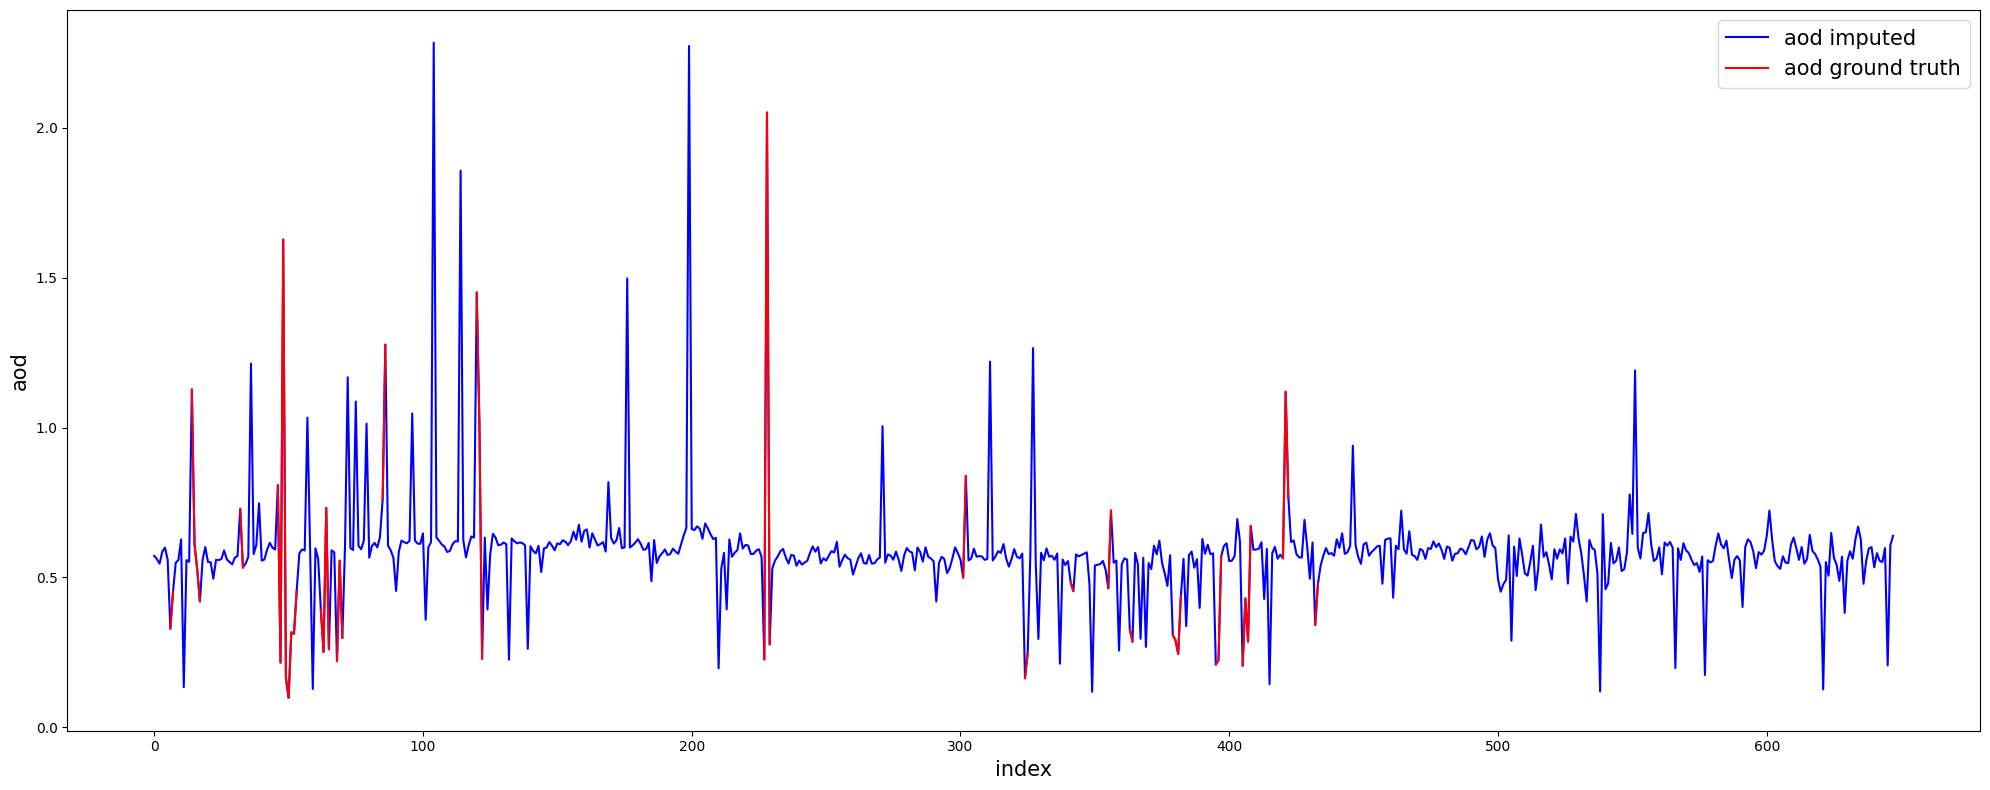


Handling for station 211



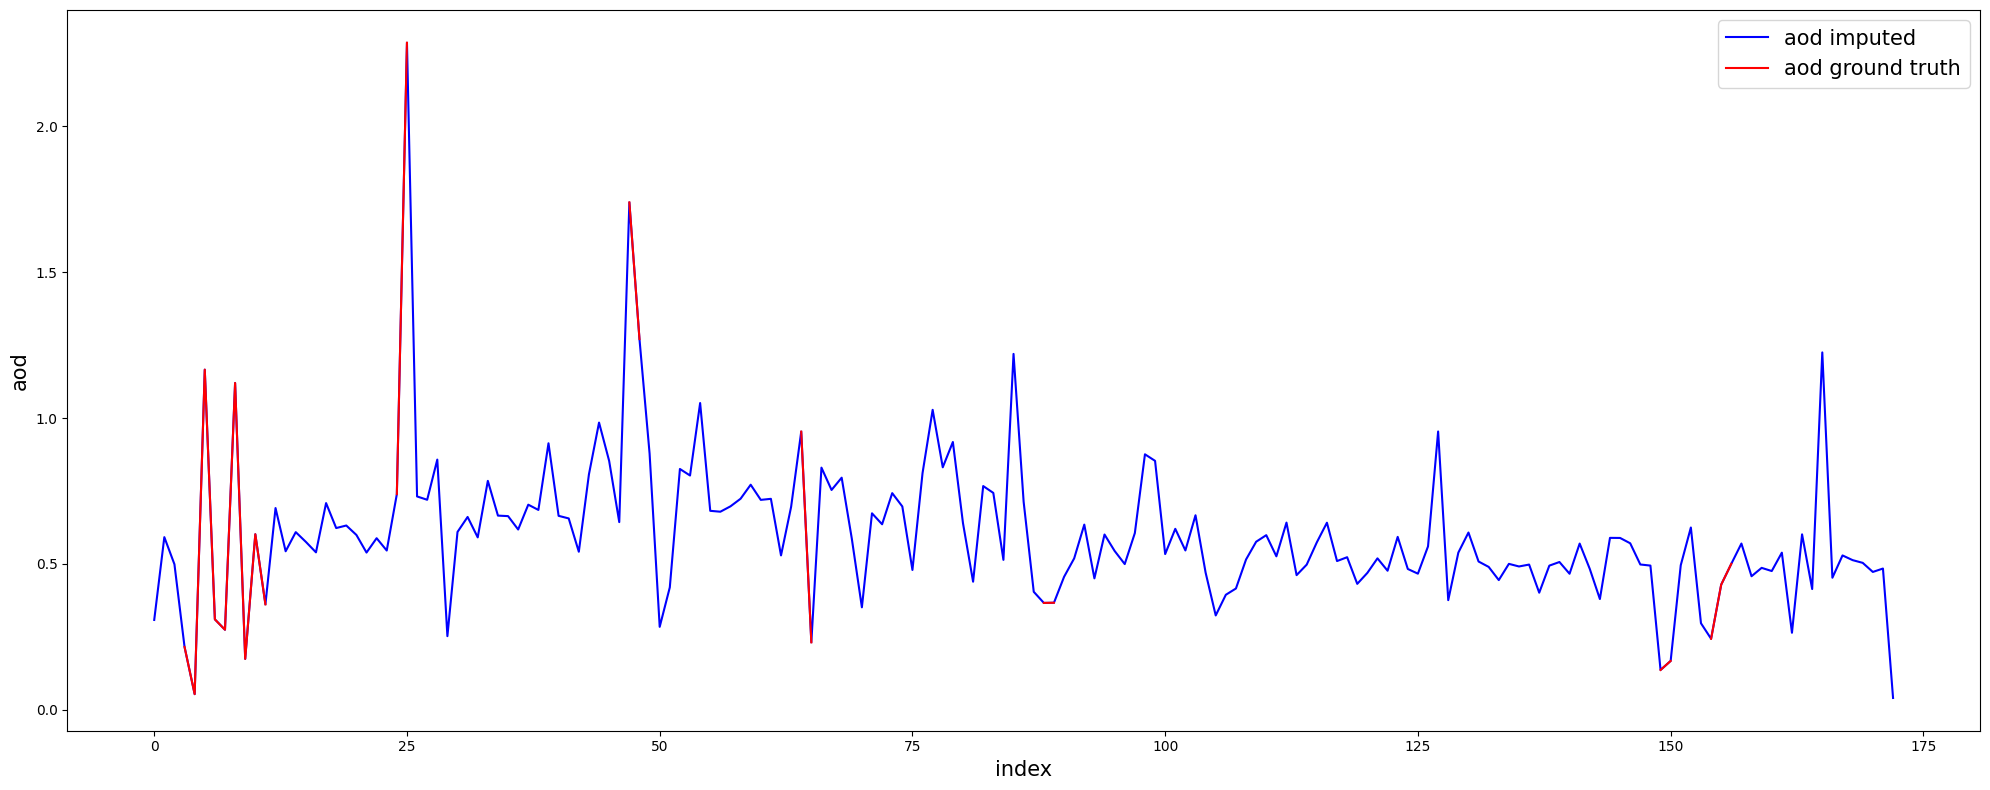


Handling for station 212



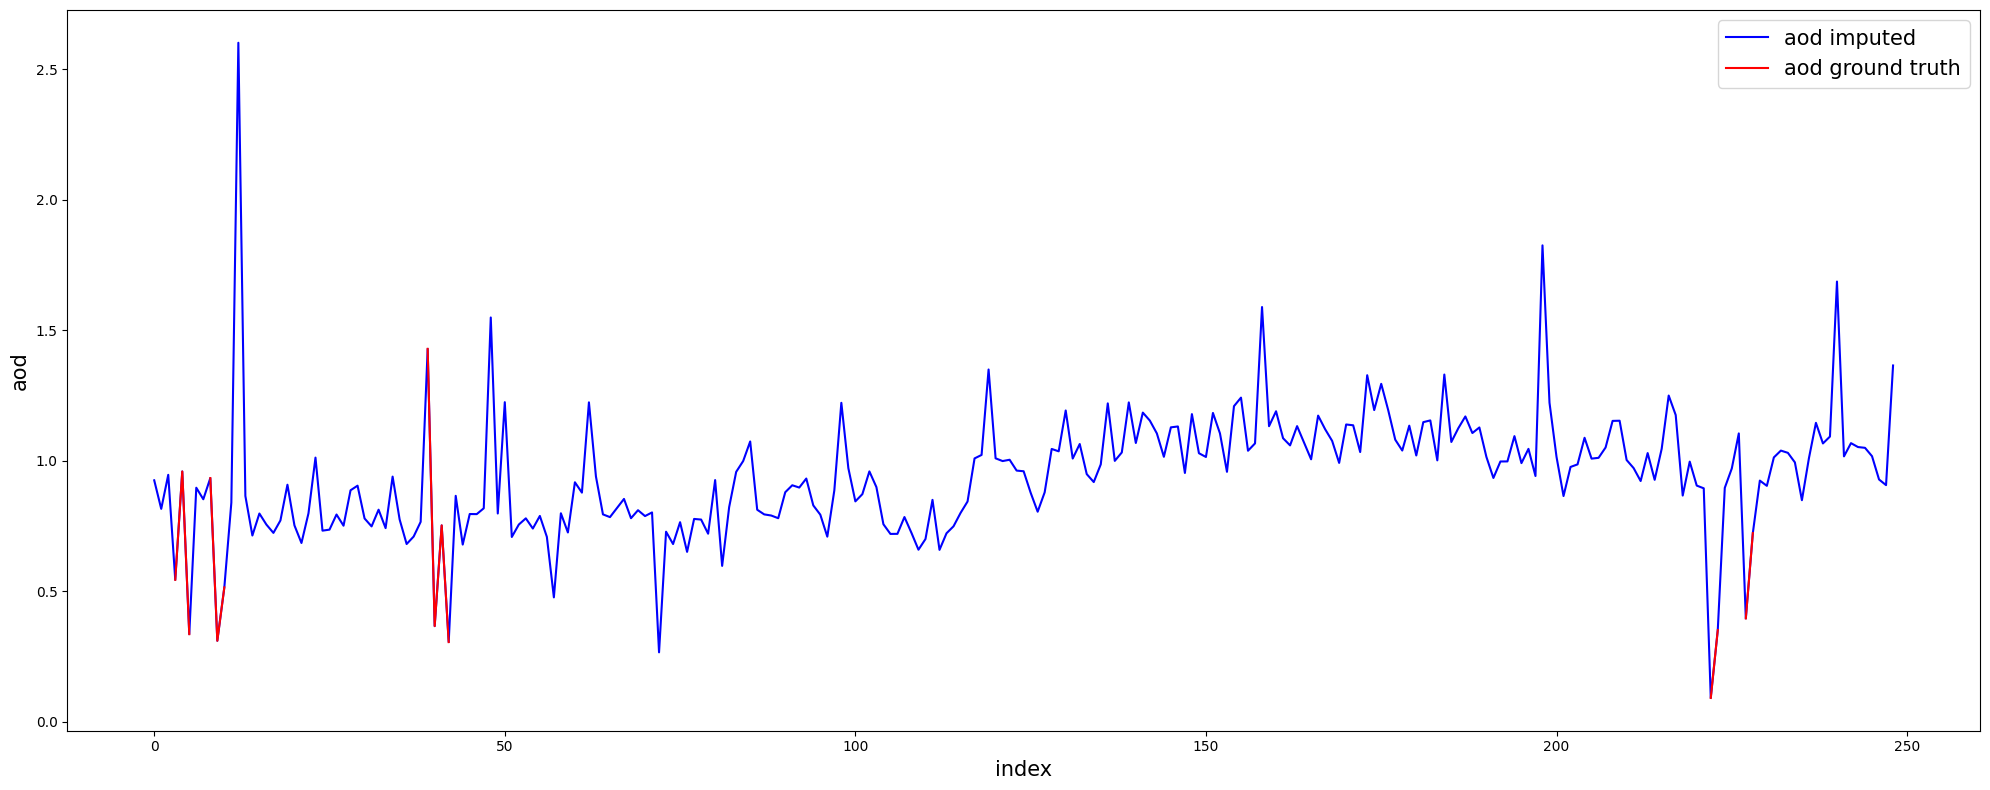


Handling for station 213



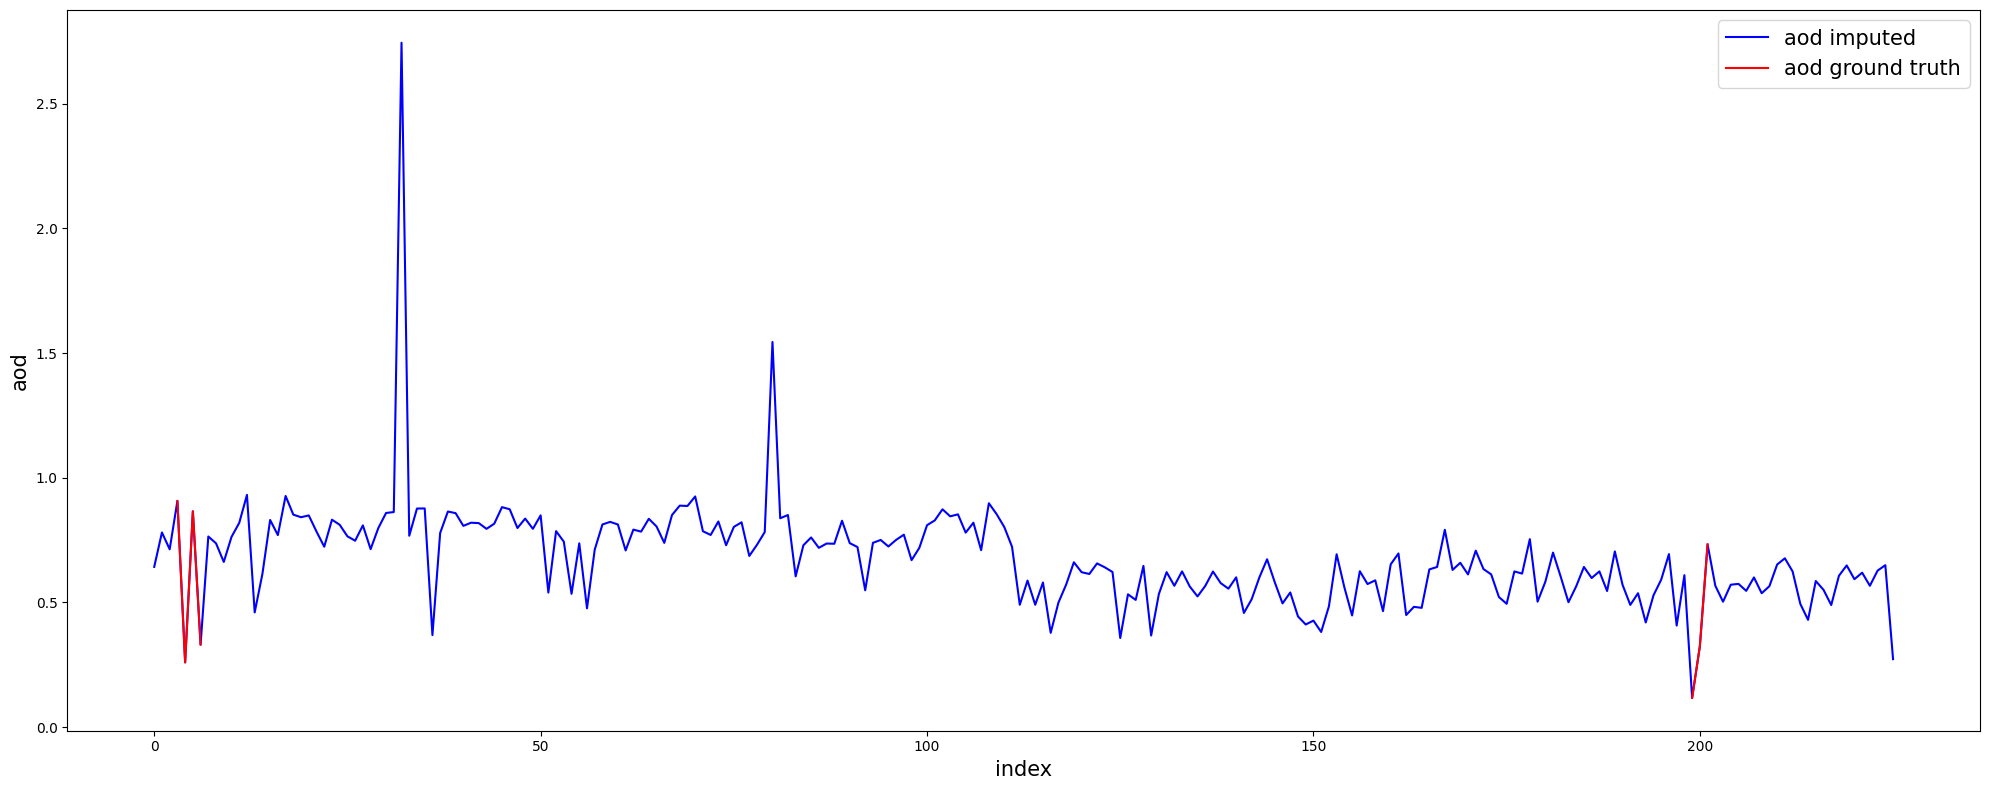


Handling for station 214



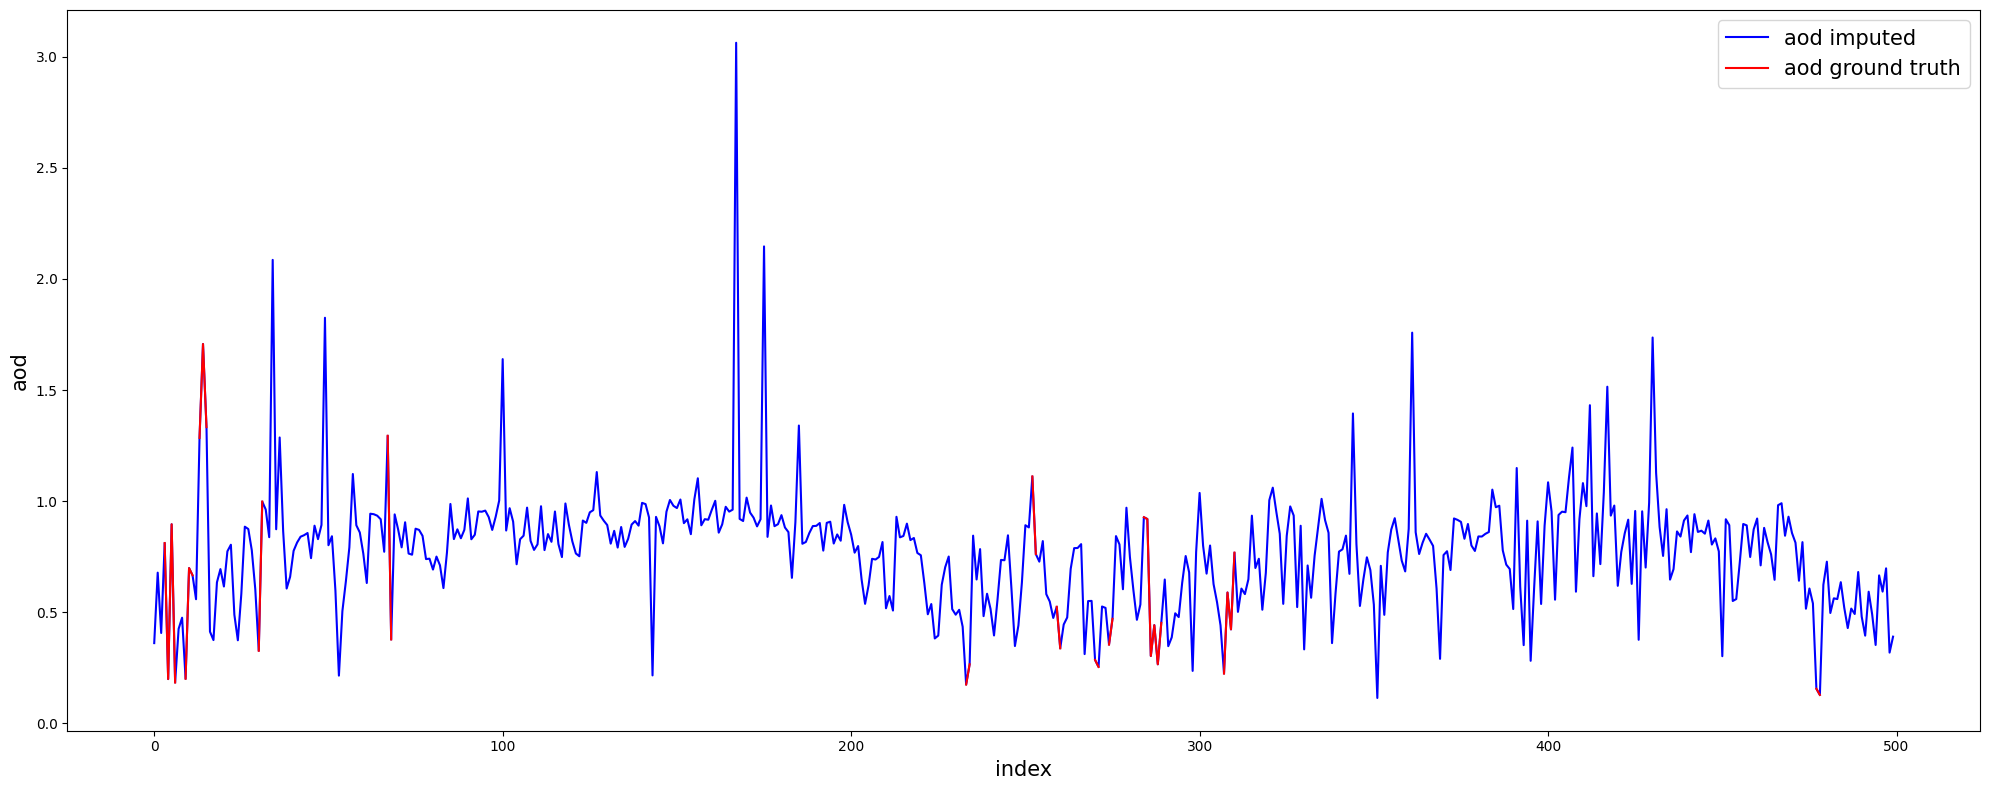


Handling for station 215



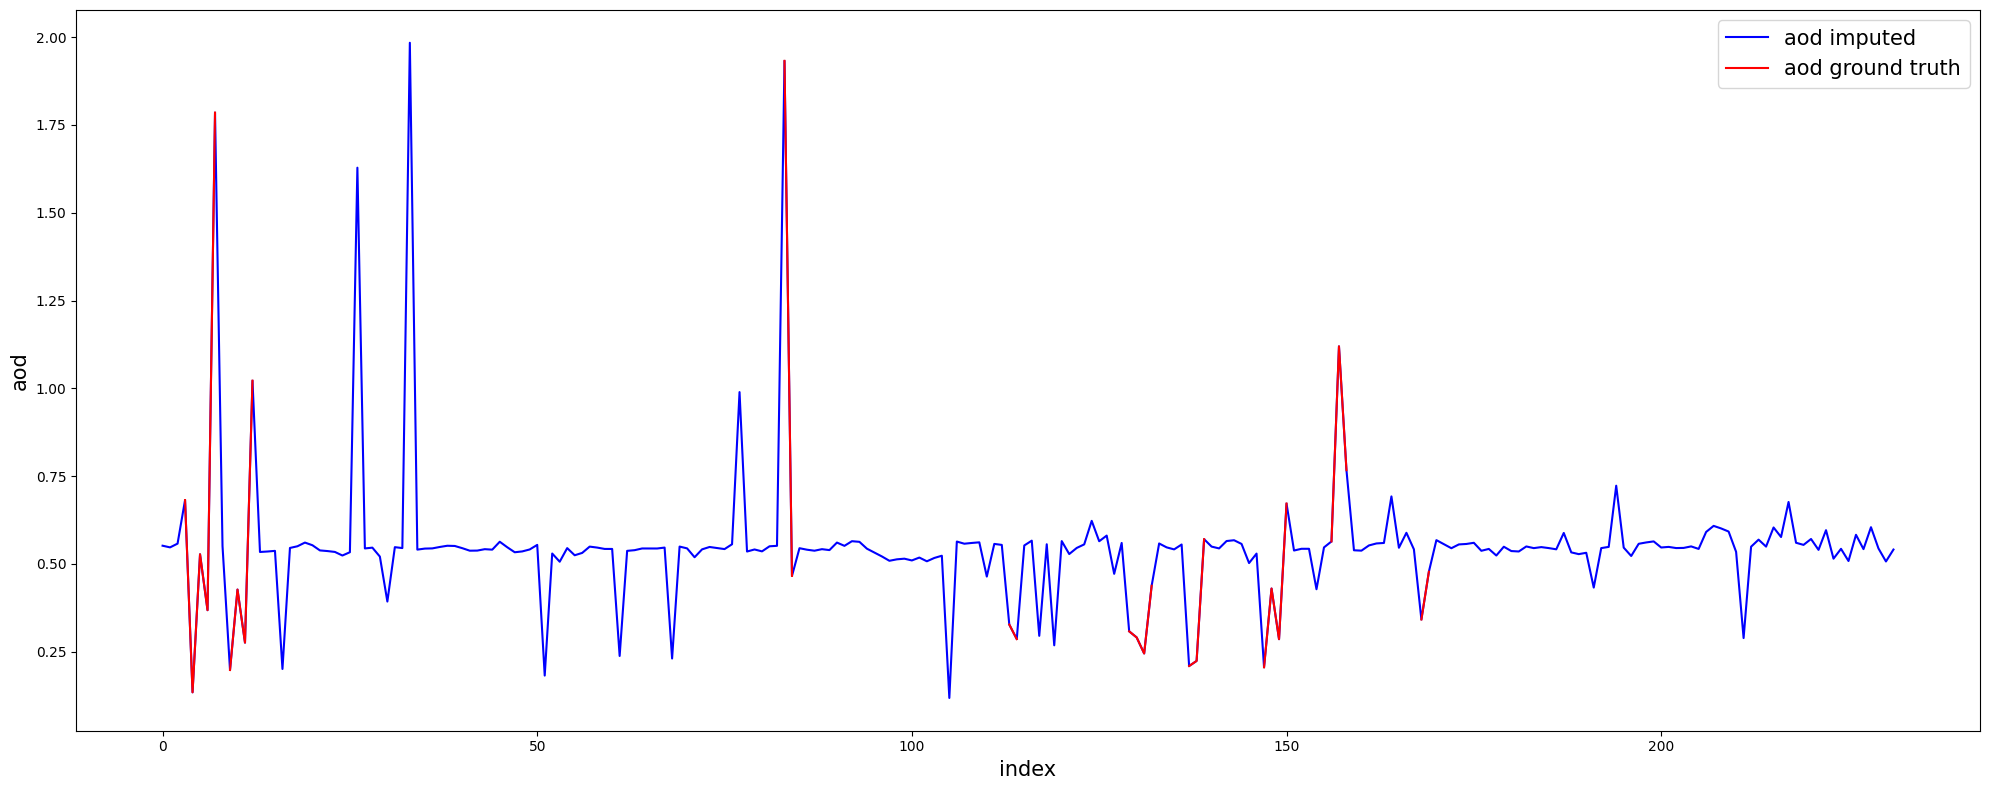


Handling for station 216



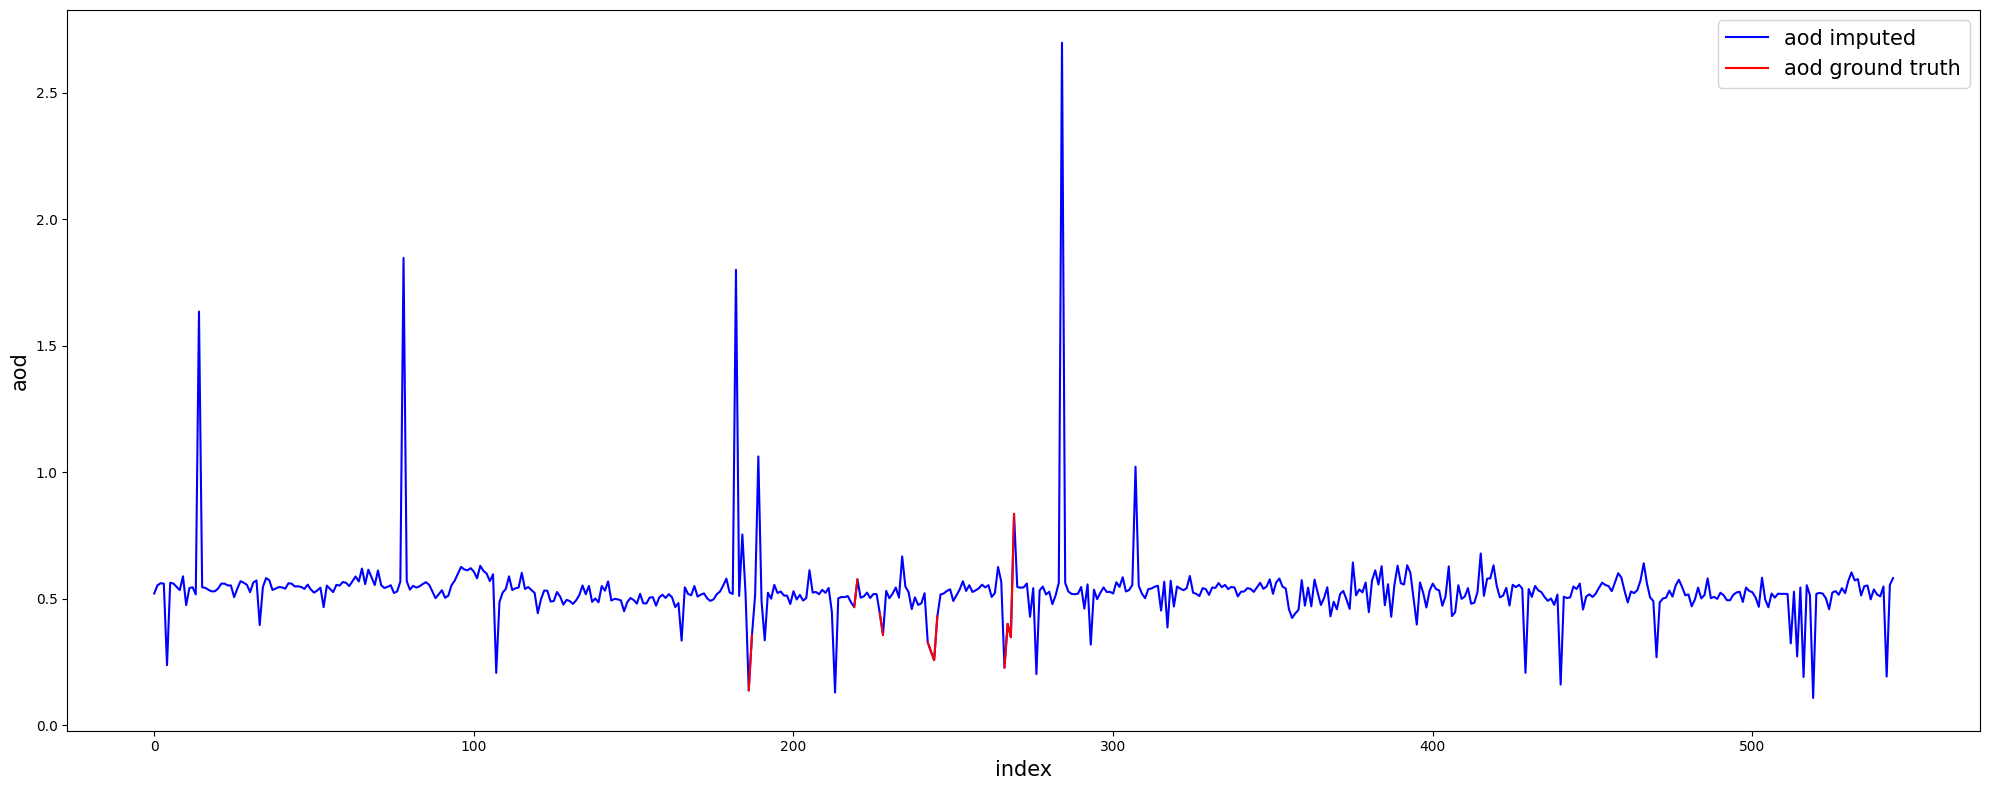

,station,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,201,17.250000,10.783057,106.700606,38.320000,25.873598,60.583508,561.605774,3.548874,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.571852
2021-01-02,201,23.000000,10.783057,106.700606,56.650002,25.527328,60.219109,527.248901,2.355864,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.561221
2021-01-03,201,28.291667,10.783057,106.700606,56.900002,26.878422,61.481564,469.774841,1.896463,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.546221
2021-01-04,201,28.791667,10.783057,106.700606,61.560001,27.771753,61.013718,615.690735,1.642178,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.586047
2021-01-05,201,24.833333,10.783057,106.700606,69.949997,27.660774,61.277409,665.619263,2.859253,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.599603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,216,39.659816,10.780482,106.659511,34.439411,24.136936,73.973083,457.798645,2.002987,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.508564
2022-12-28,216,44.679352,10.780482,106.659511,29.838476,25.844296,65.530487,644.974548,2.298220,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.547594
2022-12-29,216,30.724708,10.780482,106.659511,28.450829,25.841156,67.093735,825.517395,2.823764,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.191691


In [46]:
all_stations_df = []

for station in aod_all_stations:
    print(f"\nHandling for station {station}\n")
    # Get dataframe of current station
    df_aod_current_station = df_aod_raw[df_aod_raw["station"] == station]
    
    # Fill "aod" column
    #df_aod_current_station.loc[:, "aod"] = df_aod_current_station.loc[:, "aod"].fillna(df_aod_current_station.loc[:, "aod"].mean())
    df_aod_current_station_imputed = copy.deepcopy(df_aod_current_station)
    df_aod_current_station_imputed.loc[:, "aod"] = mice(df_aod_current_station_imputed.drop(columns=["station", "pm25"]))["aod"]
    plot_2_data(data1=df_aod_current_station_imputed["aod"],
               datalabel1="aod imputed",
               data2=df_aod_current_station["aod"],
               datalabel2="aod ground truth",
               ylabel="aod",
               xlabel="index")

    # Store file for debugging after filling missing values
    df_aod_current_station_imputed.to_csv(f"{conf['workspace']['data_by_station_dir']}/df_aod_{station}.csv", index=True)

    # Reappend the location to dataset
    all_stations_df.append(df_aod_current_station_imputed)

# Merge all stations
df_aod = pd.concat(all_stations_df)
df_aod

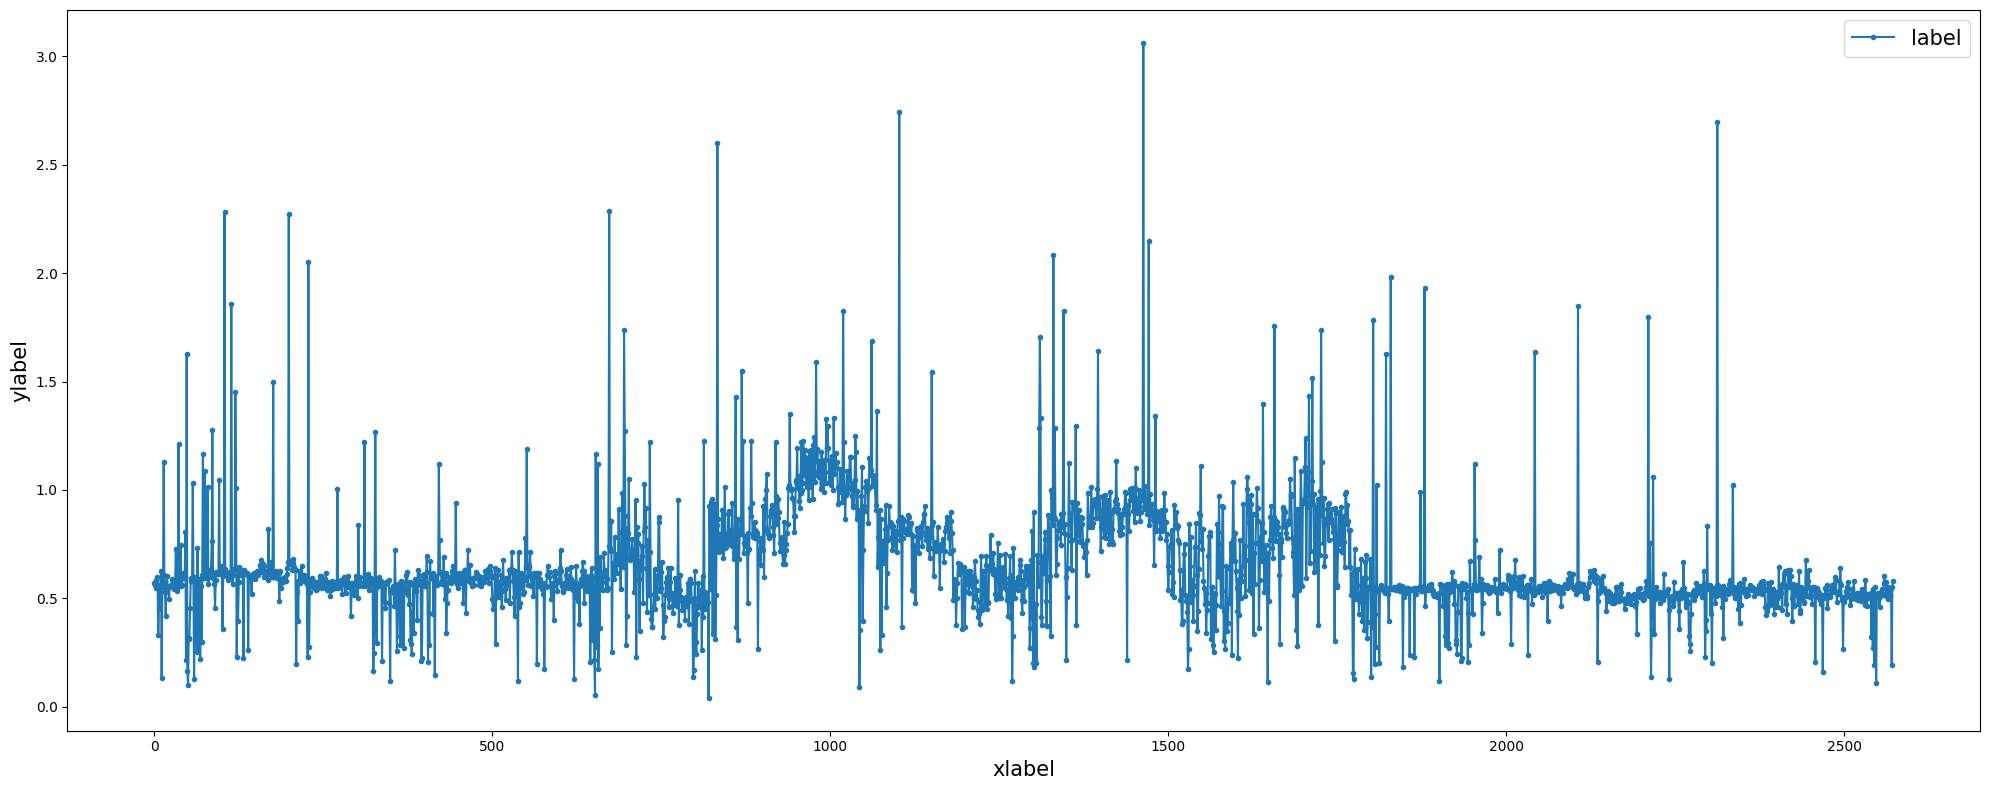

In [47]:
plot_1_data(df_aod["aod"])

In [48]:
df_aod.to_csv('df_aod.csv', index=True)

### Extract columns: time, stations, pm25_3km

In [49]:
# Get the time indices
aod_time_indices = df_aod.index
aod_time_indices

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='time', length=2573, freq=None)

In [50]:
# Get the station column
aod_station_column = df_aod.loc[:, "station"]
aod_station_column

time
2021-01-01    201
2021-01-02    201
2021-01-03    201
2021-01-04    201
2021-01-05    201
             ... 
2022-12-27    216
2022-12-28    216
2022-12-29    216
2022-12-30    216
2022-12-31    216
Name: station, Length: 2573, dtype: int64

In [51]:
# Get the pm25_3km column
aod_pm25_3km_column = df_aod.loc[:, "pm25_3km"]
aod_pm25_3km_column

time
2021-01-01    38.320000
2021-01-02    56.650002
2021-01-03    56.900002
2021-01-04    61.560001
2021-01-05    69.949997
                ...    
2022-12-27    34.439411
2022-12-28    29.838476
2022-12-29    28.450829
2022-12-30    19.854403
2022-12-31    27.658358
Name: pm25_3km, Length: 2573, dtype: float64

### Split into features and labels
* Label: pm25
* Features: other columns
    * Dynamic features
    * Static features

In [52]:
# Features with pm25_3km
aod_feats = aod_stat_feats + aod_dyn_feats

# Predict without "station" as a feature
# Remove "pm25_3km" also
aod_feats.remove("station")
aod_feats.remove("pm25_3km")
X_aod = df_aod.loc[:, aod_feats]

# Label
y_aod = df_aod.loc[:, aod_label]

In [53]:
X_aod

,lat,lon,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,tmp,wspd,hpbl,rh
time,,,,,,,,,,,,,,,,,,
2021-01-01,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.571852,25.873598,3.548874,561.605774,60.583508
2021-01-02,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.561221,25.527328,2.355864,527.248901,60.219109
2021-01-03,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.546221,26.878422,1.896463,469.774841,61.481564
2021-01-04,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.586047,27.771753,1.642178,615.690735,61.013718
2021-01-05,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.599603,27.660774,2.859253,665.619263,61.277409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,10.780482,106.659511,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.508564,24.136936,2.002987,457.798645,73.973083
2022-12-28,10.780482,106.659511,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.547594,25.844296,2.298220,644.974548,65.530487
2022-12-29,10.780482,106.659511,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.191691,25.841156,2.823764,825.517395,67.093735


In [54]:
y_aod

,pm25
time,
2021-01-01,17.250000
2021-01-02,23.000000
2021-01-03,28.291667
2021-01-04,28.791667
2021-01-05,24.833333
...,...
2022-12-27,39.659816
2022-12-28,44.679352
2022-12-29,30.724708


### Data normalization

In [55]:
# Scaled features
aod_features_scaler = MinMaxScaler()
X_aod_scaled = aod_features_scaler.fit_transform(X_aod)
X_aod_scaled = pd.DataFrame(X_aod_scaled, columns=X_aod.columns)
X_aod_scaled

,lat,lon,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,tmp,wspd,hpbl,rh
0,0.326794,0.466551,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.175925,0.292466,0.485894,0.382113,0.265635
1,0.326794,0.466551,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.172408,0.259187,0.251463,0.355779,0.257407
2,0.326794,0.466551,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.167446,0.389039,0.161190,0.311726,0.285912
3,0.326794,0.466551,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.180620,0.474896,0.111222,0.423568,0.275348
4,0.326794,0.466551,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.185104,0.464230,0.350381,0.461837,0.281302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,0.306899,0.237227,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.154990,0.125557,0.182122,0.302546,0.567964
2569,0.306899,0.237227,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.167900,0.289650,0.240136,0.446013,0.377335
2570,0.306899,0.237227,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.050172,0.289348,0.343407,0.584396,0.412632
2571,0.306899,0.237227,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.170038,0.206556,0.553589,0.473268,0.362385


In [56]:
# Scaled label
aod_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_aod_scaled = aod_label_scaler.fit_transform(y_aod)
y_aod_scaled = pd.DataFrame(y_aod_scaled, columns=y_aod.columns)
y_aod_scaled

,pm25
0,0.147032
1,0.216931
2,0.281258
3,0.287336
4,0.239218
...,...
2568,0.419453
2569,0.480472
2570,0.310835
2571,0.339606


## Seasonal analysis

In [57]:
X_aod

,lat,lon,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,tmp,wspd,hpbl,rh
time,,,,,,,,,,,,,,,,,,
2021-01-01,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.571852,25.873598,3.548874,561.605774,60.583508
2021-01-02,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.561221,25.527328,2.355864,527.248901,60.219109
2021-01-03,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.546221,26.878422,1.896463,469.774841,61.481564
2021-01-04,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.586047,27.771753,1.642178,615.690735,61.013718
2021-01-05,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.599603,27.660774,2.859253,665.619263,61.277409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,10.780482,106.659511,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.508564,24.136936,2.002987,457.798645,73.973083
2022-12-28,10.780482,106.659511,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.547594,25.844296,2.298220,644.974548,65.530487
2022-12-29,10.780482,106.659511,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.191691,25.841156,2.823764,825.517395,67.093735


In [58]:
y_aod.index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='time', length=2573, freq=None)

### Check each station

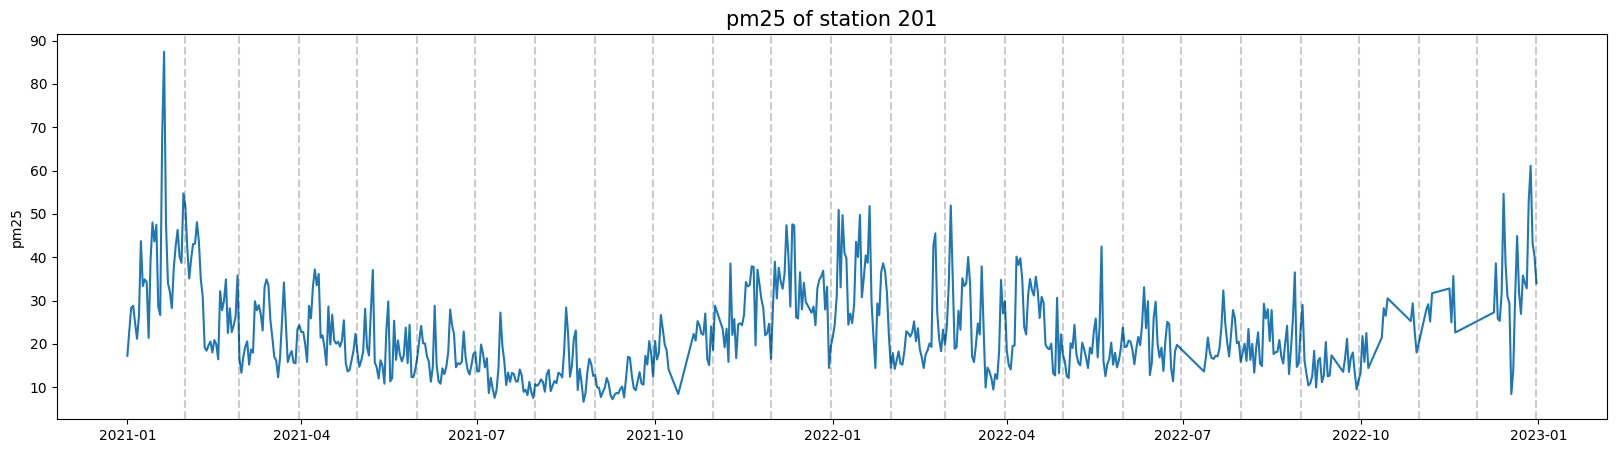

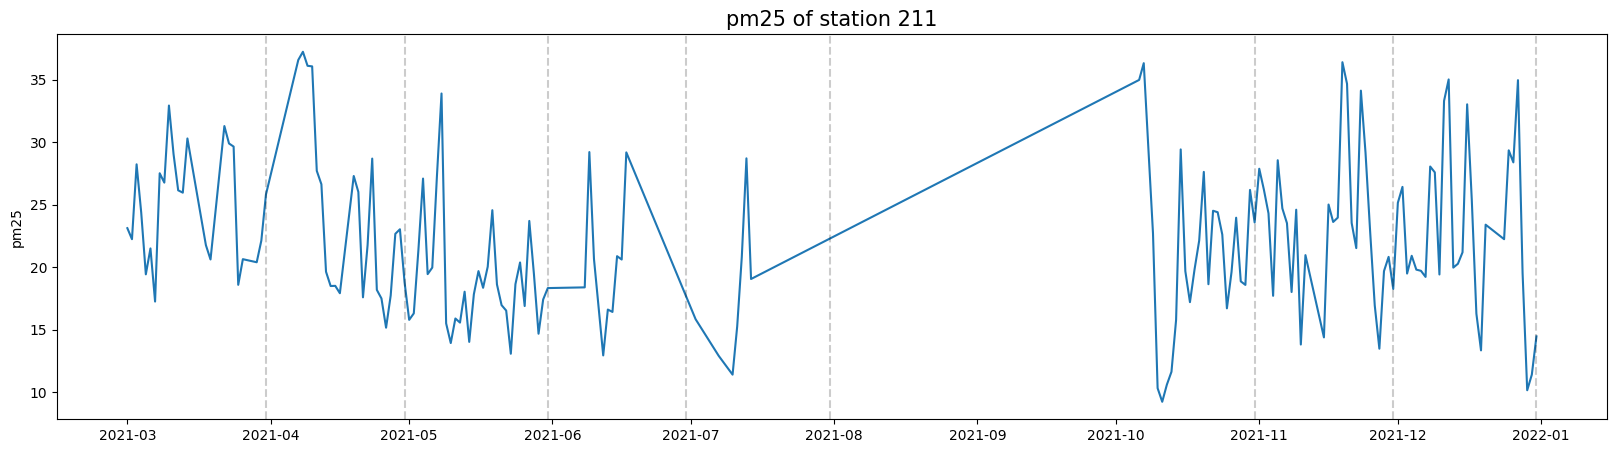

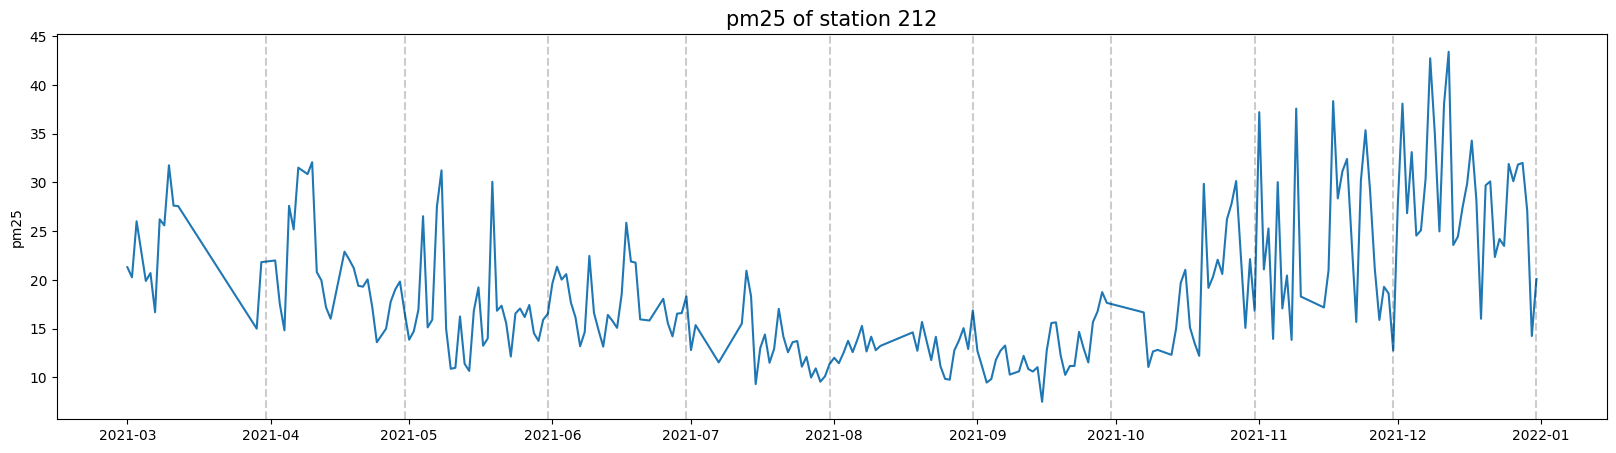

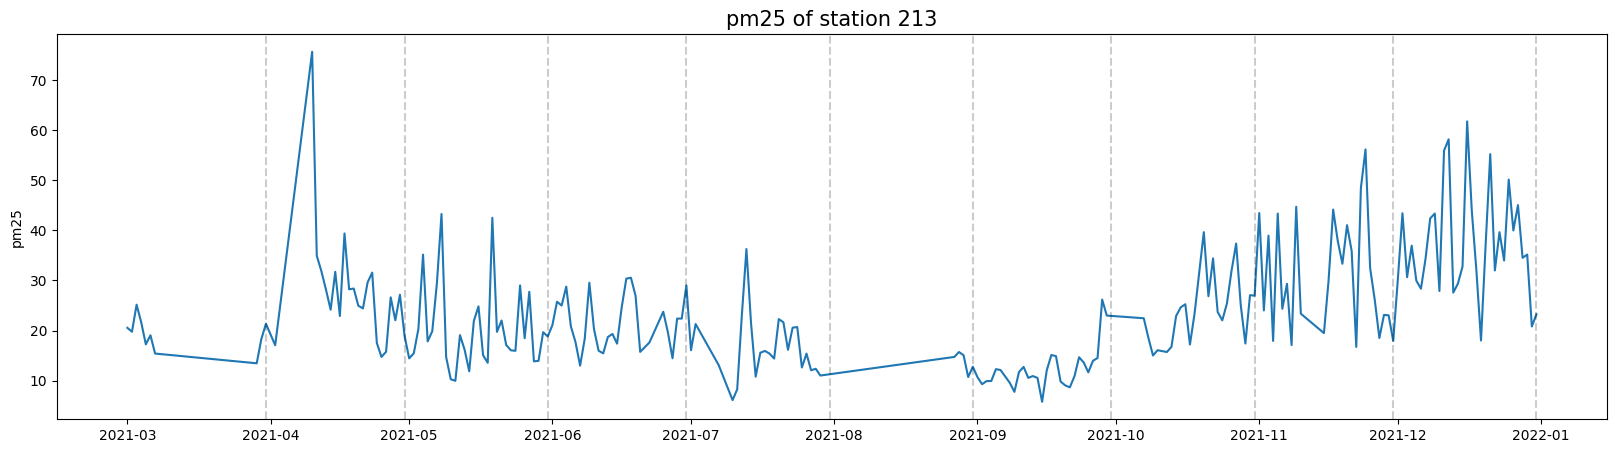

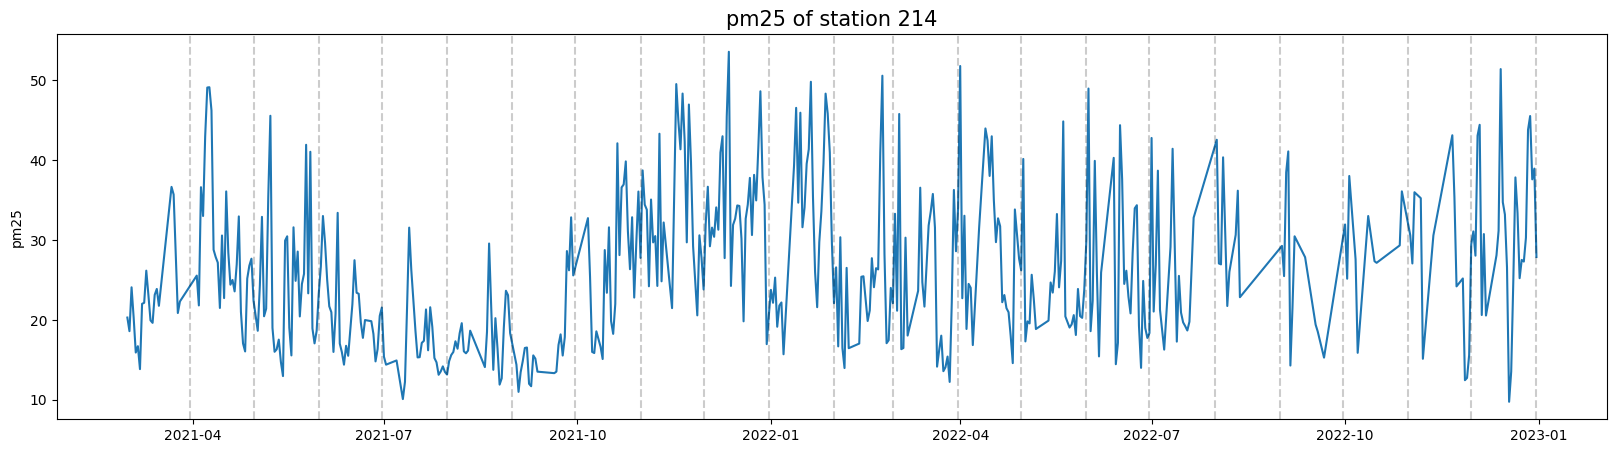

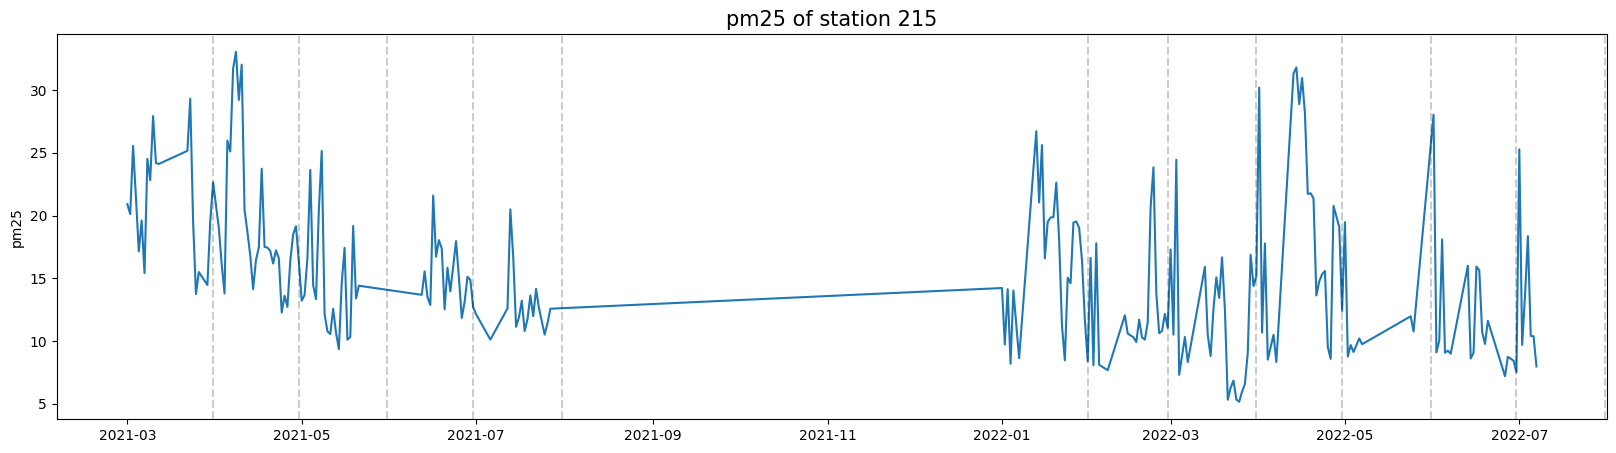

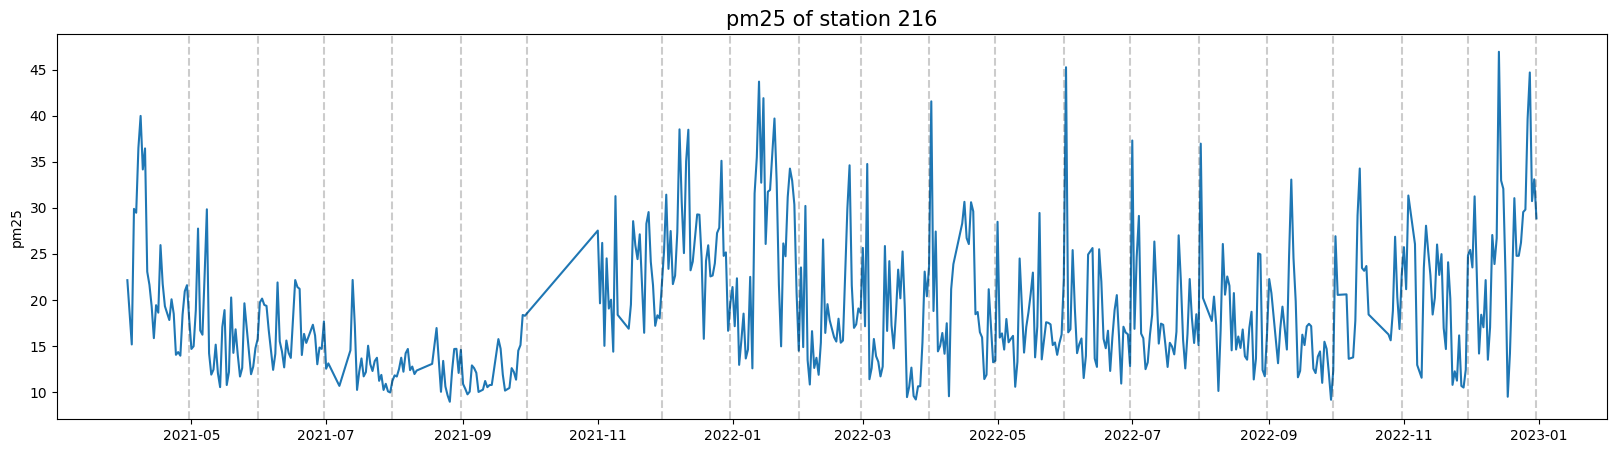

In [59]:
for station in sorted(df_aod["station"].unique()):
    pm25_current_station = df_aod[df_aod["station"] == station]["pm25"]
    plt.figure(figsize=(20, 5))
    plt.plot(pm25_current_station)
    plt.title(f'pm25 of station {station}', fontsize=15)
    plt.ylabel('pm25', fontsize=10)
    month_year_index = pm25_current_station.index.to_period("M").unique()
    for idx in month_year_index:
        plt.axvline(idx, color='k', linestyle='--', alpha=0.2)
    plt.show()

### Check the stationarity of pm25 column

In [60]:
check_stationarity(y_aod)

ADF Statistic: -5.615957
p-value: 0.000001
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Stationary


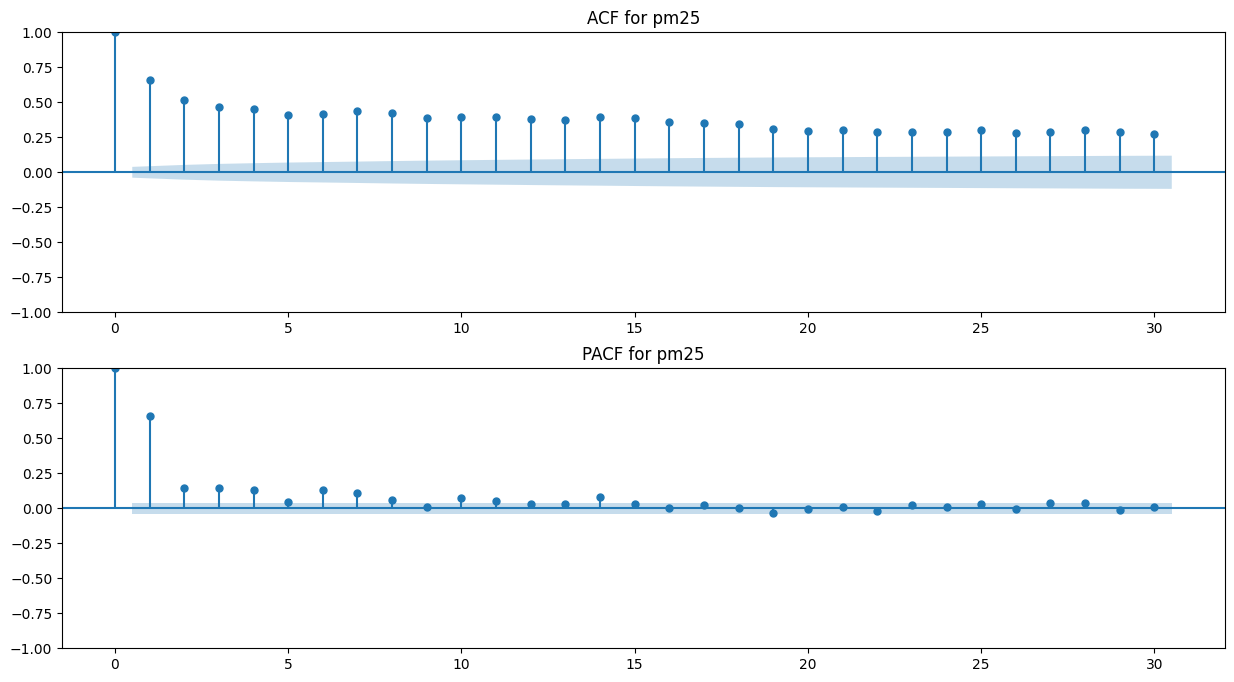

In [62]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
plot_acf(y_aod, lags=30, title="ACF for pm25", ax=ax[0])
plot_pacf(y_aod, lags=30, title="PACF for pm25", ax=ax[1], method='ols')
plt.show()

In [70]:
from statsmodels.tsa.ar_model import AutoReg

num_samples = 128

train_len = int(0.8 * num_samples)

train_len = round(len(y_aod) * 0.2)
train = y_aod[:train_len]

ar_model = AutoReg(train, lags=30).fit()
print(ar_model.summary())

pred = ar_model.predict(start=train_len, end=num_samples, dynamic=False)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(x=sample.timestamp[train_len:num_samples], y=sample.t[train_len:num_samples], marker='o', label='test', color='grey')
sns.lineplot(x=sample.timestamp[:train_len], y=train, marker='o', label='train')
sns.lineplot(x=sample.timestamp[train_len:num_samples], y=pred, marker='o', label='pred')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

                            AutoReg Model Results                             
Dep. Variable:                   pm25   No. Observations:                  515
Model:                    AutoReg(30)   Log Likelihood               -1567.694
Method:               Conditional MLE   S.D. of innovations              6.131
Date:                Sun, 31 Aug 2025   AIC                           3199.388
Time:                        14:03:26   BIC                           3333.281
Sample:                            30   HQIC                          3251.996
                                  515                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5859      0.950      2.723      0.006       0.725       4.447
pm25.L1        0.5587      0.045     12.429      0.000       0.471       0.647
pm25.L2        0.0651      0.052      1.262      0.2

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ValueError: Prediction must have `end` after `start`.